# 🎓 Aula 4: Arquiteturas Multi-Agentes e MCP

## Performance – IA para Devs | Desenvolvimento e Orquestração de Agentes de IA para o Setor Financeiro

---

### 📋 Objetivos desta Aula

Ao final desta aula, você será capaz de:

1. **Compreender Arquiteturas Multi-Agentes**: Padrões de colaboração e supervisão
2. **Implementar o padrão Supervisor**: Agente que coordena outros agentes
3. **Entender o MCP (Model Context Protocol)**: Arquitetura cliente-servidor
4. **Criar servidores MCP**: Expor ferramentas via protocolo padronizado
5. **Integrar agentes das aulas anteriores**: Criar o "Squad Financeiro"
6. **Construir o projeto final**: Sistema completo de atendimento financeiro

---

### 🛠️ Stack Tecnológico

- **Python 3.10+**
- **LangGraph** - Orquestração de agentes
- **LangChain** - Framework para LLMs
- **MCP SDK** - Model Context Protocol
- **Pydantic** - Validação de dados

---

### 📚 Pré-requisitos

- Ter completado as **Aulas 1, 2 e 3**
- Entendimento de **Agentes, RAG e LangGraph**

---

## 🚀 Parte 0: Configuração do Ambiente

Vamos instalar todas as dependências necessárias para esta aula.

In [1]:
# Instalação das dependências

%pip install langgraph langchain langchain-openai langchain-core --quiet
%pip install pydantic python-dotenv --quiet
%pip install mcp --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Configuração das variáveis de ambiente

import os
from dotenv import load_dotenv

load_dotenv()

if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = "-"  # Substitua pela sua chave

print("✅ Ambiente configurado com sucesso!")
print(f"🔑 API Key configurada: {'Sim' if os.getenv('OPENAI_API_KEY') and os.getenv('OPENAI_API_KEY') != '-' else 'Não - Configure sua chave!'}")

✅ Ambiente configurado com sucesso!
🔑 API Key configurada: Não - Configure sua chave!


---

## 📚 Parte 1: Introdução a Sistemas Multi-Agentes

### 1.1 Por que Multi-Agentes?

Um único agente pode ficar **sobrecarregado** quando precisa:
- Dominar muitas áreas diferentes
- Usar dezenas de ferramentas
- Tomar decisões complexas em múltiplos domínios

**Solução**: Dividir responsabilidades entre **agentes especializados**!

### 1.2 Padrões de Arquitetura Multi-Agentes

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                     PADRÕES DE ARQUITETURA MULTI-AGENTES                     │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                              │
│  1. HIERÁRQUICO (Supervisor)          2. SEQUENCIAL (Pipeline)               │
│  ┌──────────────────────┐             ┌─────┐   ┌─────┐   ┌─────┐            │
│  │     SUPERVISOR       │             │  A  │ → │  B  │ → │  C  │            │
│  │   (Coordenador)      │             └─────┘   └─────┘   └─────┘            │
│  └──────────┬───────────┘                                                    │
│       ┌─────┼─────┐                                                          │
│       ▼     ▼     ▼                   3. COLABORATIVO (Peer-to-Peer)         │
│    ┌─────┬─────┬─────┐               ┌─────┐ ←→ ┌─────┐                       │
│    │  A  │  B  │  C  │               │  A  │    │  B  │                       │
│    └─────┴─────┴─────┘               └──┬──┘    └──┬──┘                       │
│    Agentes Especializados               │    ↖  ↗  │                         │
│                                         └─→ ┌─────┐ ←┘                        │
│                                             │  C  │                          │
│  4. REDE (Network)                         └─────┘                           │
│  ┌─────┐     ┌─────┐                                                         │
│  │  A  │ ←─→ │  B  │                 5. HIERÁRQUICO MULTI-NÍVEL              │
│  └──┬──┘     └──┬──┘                 ┌──────────────────────┐                │
│     │    ╲  ╱   │                    │      SUPERVISOR      │                │
│     │     ╲╱    │                    └──────────┬───────────┘                │
│     │     ╱╲    │                         ┌─────┴─────┐                      │
│     │    ╱  ╲   │                         ▼           ▼                      │
│  ┌──┴──┐     ┌──┴──┐                 ┌─────────┐  ┌─────────┐                │
│  │  C  │ ←─→ │  D  │                 │ SUB-SUP │  │ SUB-SUP │                │
│  └─────┘     └─────┘                 └────┬────┘  └────┬────┘                │
│                                       ┌──┴──┐      ┌──┴──┐                   │
│                                       │A│ │B│      │C│ │D│                   │
│                                       └───┘        └───┘                     │
└─────────────────────────────────────────────────────────────────────────────┘
```

### 1.3 Nesta Aula: Padrão Supervisor

Vamos implementar o padrão **Supervisor**, onde:
- Um agente **Supervisor** recebe todas as requisições
- Ele **analisa** a tarefa e **delega** ao agente especializado
- O agente especializado **executa** e retorna ao supervisor
- O supervisor **consolida** e entrega a resposta final

---

In [28]:
# Imports necessários para toda a aula

from typing import TypedDict, Annotated, Literal, Optional, List, Dict, Any
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel, Field
from datetime import datetime
import operator
import json

# LLM principal
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

print("✅ Imports realizados com sucesso!")

✅ Imports realizados com sucesso!


---

## 📚 Parte 2: Criando os Agentes Especializados

Vamos criar 4 agentes especializados para nosso setor financeiro:

1. **Agente de Cotações**: Consulta preços e indicadores de mercado
2. **Agente de Clientes**: Gerencia informações de clientes
3. **Agente de Compliance**: Verifica regulamentações e riscos
4. **Agente de Crédito**: Analisa e processa solicitações de crédito

In [32]:
# ============ AGENTE 1: Cotações de Mercado ============

from langchain_core.tools import tool

@tool
def consultar_cotacao(ativo: str) -> str:
    """Consulta a cotação atual de um ativo (ação, índice, moeda)."""
    # Dados simulados
    cotacoes = {
        "PETR4": {"preco": 38.52, "variacao": 2.3, "volume": 45000000},
        "VALE3": {"preco": 62.80, "variacao": -1.5, "volume": 32000000},
        "ITUB4": {"preco": 32.15, "variacao": 0.8, "volume": 28000000},
        "BBDC4": {"preco": 12.45, "variacao": 1.2, "volume": 25000000},
        "IBOV": {"preco": 128500, "variacao": 0.5, "volume": 0},
        "USD": {"preco": 5.12, "variacao": -0.3, "volume": 0},
        "EUR": {"preco": 5.58, "variacao": 0.1, "volume": 0},
    }
    
    ativo_upper = ativo.upper()
    if ativo_upper in cotacoes:
        dados = cotacoes[ativo_upper]
        sinal = "+" if dados["variacao"] > 0 else ""
        return f"{ativo_upper}: R$ {dados['preco']:.2f} ({sinal}{dados['variacao']}%)"
    return f"Ativo '{ativo}' não encontrado."

@tool
def consultar_indicadores_mercado() -> str:
    """Retorna os principais indicadores do mercado financeiro."""
    return """📊 INDICADORES DE MERCADO:
• IBOVESPA: 128.500 pts (+0.5%)
• IFIX: 3.245 pts (+0.2%)
• Dólar: R$ 5.12 (-0.3%)
• Euro: R$ 5.58 (+0.1%)
• SELIC: 13.75% a.a.
• IPCA (12m): 4.5%
• CDI: 13.65% a.a."""

@tool
def consultar_historico(ativo: str, periodo: str = "1m") -> str:
    """Consulta o histórico de preços de um ativo."""
    return f"""📈 HISTÓRICO {ativo.upper()} ({periodo}):
• Máxima: R$ 42.30
• Mínima: R$ 35.80
• Média: R$ 38.90
• Volatilidade: 18.5%
• Tendência: ALTA"""

ferramentas_cotacoes = [consultar_cotacao, consultar_indicadores_mercado, consultar_historico]

print("✅ Ferramentas do Agente de Cotações definidas!")

✅ Ferramentas do Agente de Cotações definidas!


In [33]:
# ============ AGENTE 2: Gestão de Clientes ============

@tool
def consultar_cliente(cpf_cnpj: str) -> str:
    """Consulta dados cadastrais de um cliente pelo CPF ou CNPJ."""
    clientes = {
        "123.456.789-00": {
            "nome": "Maria Silva Santos",
            "tipo": "PF",
            "segmento": "Private",
            "desde": "2018-03-15",
            "gerente": "Carlos Eduardo",
            "patrimonio": 2500000
        },
        "987.654.321-00": {
            "nome": "João Pedro Oliveira",
            "tipo": "PF",
            "segmento": "Varejo Alta Renda",
            "desde": "2020-08-22",
            "gerente": "Ana Paula",
            "patrimonio": 450000
        },
        "12.345.678/0001-90": {
            "nome": "Tech Solutions Ltda",
            "tipo": "PJ",
            "segmento": "Corporate",
            "desde": "2019-01-10",
            "gerente": "Roberto Mendes",
            "faturamento_anual": 15000000
        }
    }
    
    if cpf_cnpj in clientes:
        c = clientes[cpf_cnpj]
        return f"""👤 CLIENTE: {c['nome']}
• Tipo: {c['tipo']}
• Segmento: {c['segmento']}
• Cliente desde: {c['desde']}
• Gerente: {c['gerente']}"""
    return f"Cliente com documento '{cpf_cnpj}' não encontrado."

@tool
def consultar_produtos_cliente(cpf_cnpj: str) -> str:
    """Lista os produtos contratados por um cliente."""
    return f"""📦 PRODUTOS DO CLIENTE:
• Conta Corrente: Ativa
• Cartão de Crédito: Platinum (limite R$ 25.000)
• Investimentos: R$ 180.000 (CDB, LCI, Fundos)
• Previdência: R$ 85.000
• Seguro de Vida: Ativo (capital R$ 500.000)"""

@tool
def consultar_extrato(cpf_cnpj: str, dias: int = 30) -> str:
    """Consulta o extrato de movimentações de um cliente."""
    return f"""📋 EXTRATO (últimos {dias} dias):
• Saldo atual: R$ 45.230,50
• Entradas: R$ 28.500,00
• Saídas: R$ 22.150,00
• Maior entrada: R$ 15.000,00 (TED recebida)
• Maior saída: R$ 8.500,00 (Pagamento fatura)"""

ferramentas_clientes = [consultar_cliente, consultar_produtos_cliente, consultar_extrato]

print("✅ Ferramentas do Agente de Clientes definidas!")

✅ Ferramentas do Agente de Clientes definidas!


In [34]:
# ============ AGENTE 3: Compliance e Riscos ============

@tool
def verificar_pld(cpf_cnpj: str) -> str:
    """Verifica o status PLD (Prevenção à Lavagem de Dinheiro) de um cliente."""
    return f"""🔍 VERIFICAÇÃO PLD:
• Status: ✅ REGULAR
• Última atualização: {datetime.now().strftime('%Y-%m-%d')}
• Alertas: Nenhum
• Movimentações atípicas: Não identificadas
• PEP (Pessoa Exposta Politicamente): Não"""

@tool
def verificar_restricoes(cpf_cnpj: str) -> str:
    """Verifica restrições cadastrais de um cliente."""
    return f"""⚠️ VERIFICAÇÃO DE RESTRIÇÕES:
• Serasa: Nada consta
• SPC: Nada consta
• BACEN: Regular
• Protestos: Nenhum
• Ações judiciais: Nenhuma"""

@tool
def consultar_regulamentacao(tema: str) -> str:
    """Consulta regulamentações aplicáveis a um tema específico."""
    regulamentacoes = {
        "credito": """📜 REGULAMENTAÇÃO - CRÉDITO:
• Resolução CMN 4.949/2021: Operações de crédito
• Circular BACEN 3.978/2020: PLD/FT
• Limite de comprometimento de renda: 30%
• Taxa máxima de juros: Conforme CMN""",
        "investimentos": """📜 REGULAMENTAÇÃO - INVESTIMENTOS:
• Instrução CVM 555: Fundos de investimento
• Suitability obrigatório (CVM 539)
• Prazo D+0 a D+30 conforme produto""",
        "pix": """📜 REGULAMENTAÇÃO - PIX:
• Limite noturno: R$ 1.000
• Limite diurno: Conforme cliente
• MED (Mecanismo Especial de Devolução)"""
    }
    return regulamentacoes.get(tema.lower(), f"Regulamentação sobre '{tema}' não encontrada.")

@tool
def calcular_risco_operacao(valor: float, tipo: str) -> str:
    """Calcula o nível de risco de uma operação."""
    if valor > 500000:
        nivel = "ALTO"
        msg = "Requer aprovação da diretoria"
    elif valor > 100000:
        nivel = "MÉDIO"
        msg = "Requer aprovação do gerente regional"
    else:
        nivel = "BAIXO"
        msg = "Aprovação automática disponível"
    
    return f"""🎯 ANÁLISE DE RISCO:
• Operação: {tipo}
• Valor: R$ {valor:,.2f}
• Nível de Risco: {nivel}
• Observação: {msg}"""

ferramentas_compliance = [verificar_pld, verificar_restricoes, consultar_regulamentacao, calcular_risco_operacao]

print("✅ Ferramentas do Agente de Compliance definidas!")

✅ Ferramentas do Agente de Compliance definidas!


In [35]:
# ============ AGENTE 4: Análise de Crédito ============

@tool
def simular_emprestimo(valor: float, prazo: int, taxa: float = 1.99) -> str:
    """Simula um empréstimo pessoal."""
    # Cálculo de Price
    taxa_mensal = taxa / 100
    parcela = valor * (taxa_mensal * (1 + taxa_mensal)**prazo) / ((1 + taxa_mensal)**prazo - 1)
    total = parcela * prazo
    
    return f"""💰 SIMULAÇÃO DE EMPRÉSTIMO:
• Valor solicitado: R$ {valor:,.2f}
• Prazo: {prazo} meses
• Taxa: {taxa}% a.m.
• Parcela: R$ {parcela:,.2f}
• Total a pagar: R$ {total:,.2f}
• CET: {taxa * 1.15:.2f}% a.m."""

@tool
def simular_financiamento(valor: float, entrada: float, prazo: int) -> str:
    """Simula um financiamento de veículo ou imóvel."""
    valor_financiado = valor - entrada
    taxa = 0.99 if prazo <= 48 else 1.29
    taxa_mensal = taxa / 100
    parcela = valor_financiado * (taxa_mensal * (1 + taxa_mensal)**prazo) / ((1 + taxa_mensal)**prazo - 1)
    
    return f"""🏠 SIMULAÇÃO DE FINANCIAMENTO:
• Valor do bem: R$ {valor:,.2f}
• Entrada: R$ {entrada:,.2f} ({entrada/valor*100:.1f}%)
• Valor financiado: R$ {valor_financiado:,.2f}
• Prazo: {prazo} meses
• Taxa: {taxa}% a.m.
• Parcela: R$ {parcela:,.2f}"""

@tool
def consultar_limite_credito(cpf_cnpj: str) -> str:
    """Consulta o limite de crédito pré-aprovado de um cliente."""
    return f"""💳 LIMITE DE CRÉDITO PRÉ-APROVADO:
• Empréstimo Pessoal: R$ 80.000
• Cheque Especial: R$ 15.000
• Cartão de Crédito: R$ 25.000
• Financiamento Veículo: R$ 150.000
• Financiamento Imóvel: R$ 500.000
• Crédito Consignado: R$ 120.000"""

@tool
def analisar_capacidade_pagamento(renda: float, despesas: float, parcela_pretendida: float) -> str:
    """Analisa a capacidade de pagamento do cliente."""
    disponivel = renda - despesas
    comprometimento_atual = (despesas / renda) * 100
    comprometimento_novo = ((despesas + parcela_pretendida) / renda) * 100
    
    if comprometimento_novo > 35:
        parecer = "❌ NÃO RECOMENDADO - Comprometimento acima de 35%"
    elif comprometimento_novo > 30:
        parecer = "⚠️ ATENÇÃO - Comprometimento entre 30-35%"
    else:
        parecer = "✅ APROVADO - Capacidade de pagamento adequada"
    
    return f"""📊 ANÁLISE DE CAPACIDADE:
• Renda: R$ {renda:,.2f}
• Despesas atuais: R$ {despesas:,.2f}
• Disponível: R$ {disponivel:,.2f}
• Comprometimento atual: {comprometimento_atual:.1f}%
• Comprometimento com nova parcela: {comprometimento_novo:.1f}%
• PARECER: {parecer}"""

ferramentas_credito = [simular_emprestimo, simular_financiamento, consultar_limite_credito, analisar_capacidade_pagamento]

print("✅ Ferramentas do Agente de Crédito definidas!")

✅ Ferramentas do Agente de Crédito definidas!


---

## 📚 Parte 3: Criando os Agentes com LangGraph

Agora vamos criar cada agente especializado como um nó do grafo.

In [36]:
# Definição do Estado do Sistema Multi-Agentes

class EstadoMultiAgentes(TypedDict, total=False):
    """Estado compartilhado entre todos os agentes.
    
    Usando total=False para permitir retornos parciais nos nós,
    que é o padrão em LangGraph (cada nó retorna apenas os campos que atualiza).
    """
    # Mensagens do usuário e respostas
    mensagens: Annotated[list[BaseMessage], operator.add]
    
    # Controle de roteamento
    proximo_agente: Optional[str]
    agente_atual: Optional[str]
    
    # Contexto acumulado
    contexto: Annotated[list[str], operator.add]
    
    # Resposta final
    resposta_final: Optional[str]
    
    # Controle de iterações
    iteracoes: int

print("✅ Estado do Sistema Multi-Agentes definido!")

✅ Estado do Sistema Multi-Agentes definido!


aqui

In [38]:
# Função para criar um agente especializado

from langchain_core.prompts import ChatPromptTemplate

def criar_agente(nome: str, descricao: str, ferramentas: list):
    """
    Cria um agente especializado com ferramentas específicas.
    
    Args:
        nome: Nome do agente
        descricao: Descrição do papel do agente
        ferramentas: Lista de ferramentas disponíveis
    
    Returns:
        Função que processa o estado
    """
    
    # Bind tools ao LLM
    llm_com_ferramentas = llm.bind_tools(ferramentas)
    
    # Prompt do agente
    system_prompt = f"""Você é o {nome}, um especialista em {descricao}.

SUAS RESPONSABILIDADES:
{descricao}

DIRETRIZES:
1. Use APENAS as ferramentas disponíveis para você
2. Seja preciso e objetivo nas respostas
3. Se não conseguir ajudar, indique claramente
4. Sempre formate as respostas de forma clara

IMPORTANTE: Responda em português brasileiro."""
    
    def processar(state: EstadoMultiAgentes) -> EstadoMultiAgentes:
        """Processa uma requisição com este agente."""
        print(f"\n🤖 [{nome}] Processando...")
        
        # Pega a última mensagem do usuário
        mensagens = state["mensagens"]
        
        # Prepara mensagens para o LLM
        prompt_messages = [
            SystemMessage(content=system_prompt),
            *mensagens
        ]
        
        # Invoca o LLM
        resposta = llm_com_ferramentas.invoke(prompt_messages)
        
        # Processa tool calls se houver
        if resposta.tool_calls:
            resultados = []
            for tool_call in resposta.tool_calls:
                # Encontra a ferramenta
                for ferramenta in ferramentas:
                    if ferramenta.name == tool_call["name"]:
                        resultado = ferramenta.invoke(tool_call["args"])
                        resultados.append(f"[{tool_call['name']}]: {resultado}")
                        print(f"   🔧 Ferramenta: {tool_call['name']}")
                        break
            
            # Segunda chamada com os resultados
            contexto_ferramentas = "\n".join(resultados)
            prompt_final = prompt_messages + [
                AIMessage(content=f"Resultados das consultas:\n{contexto_ferramentas}"),
                HumanMessage(content="Com base nesses resultados, formule uma resposta clara e completa.")
            ]
            resposta_final = llm.invoke(prompt_final)
            conteudo = resposta_final.content
        else:
            conteudo = resposta.content
        
        print(f"   ✅ Resposta gerada")
        
        return {
            "mensagens": [AIMessage(content=conteudo)],
            "agente_atual": nome,
            "contexto": [f"[{nome}]: {conteudo[:200]}..." if len(conteudo) > 200 else f"[{nome}]: {conteudo}"],
            "proximo_agente": "supervisor",
            "resposta_final": None,
            "iteracoes": state.get("iteracoes", 0)
        }
    
    return processar

print("✅ Função criar_agente definida!")

✅ Função criar_agente definida!


In [39]:
# Criando os 4 agentes especializados

agente_cotacoes = criar_agente(
    nome="Agente de Cotações",
    descricao="""Especialista em mercado financeiro:
    - Consultar cotações de ações, índices e moedas
    - Fornecer indicadores de mercado
    - Analisar histórico de preços
    - Informar sobre tendências de mercado""",
    ferramentas=ferramentas_cotacoes
)

agente_clientes = criar_agente(
    nome="Agente de Clientes",
    descricao="""Especialista em gestão de relacionamento:
    - Consultar dados cadastrais de clientes
    - Listar produtos contratados
    - Fornecer extratos e movimentações
    - Informar sobre benefícios e segmentos""",
    ferramentas=ferramentas_clientes
)

agente_compliance = criar_agente(
    nome="Agente de Compliance",
    descricao="""Especialista em conformidade e riscos:
    - Verificar status PLD de clientes
    - Consultar restrições cadastrais
    - Informar sobre regulamentações
    - Calcular risco de operações""",
    ferramentas=ferramentas_compliance
)

agente_credito = criar_agente(
    nome="Agente de Crédito",
    descricao="""Especialista em produtos de crédito:
    - Simular empréstimos e financiamentos
    - Consultar limites pré-aprovados
    - Analisar capacidade de pagamento
    - Recomendar produtos de crédito""",
    ferramentas=ferramentas_credito
)

print("✅ Todos os agentes especializados criados!")
print("   • Agente de Cotações")
print("   • Agente de Clientes")
print("   • Agente de Compliance")
print("   • Agente de Crédito")

✅ Todos os agentes especializados criados!
   • Agente de Cotações
   • Agente de Clientes
   • Agente de Compliance
   • Agente de Crédito


---

## 📚 Parte 4: Criando o Agente Supervisor

O Supervisor é o cérebro do sistema. Ele analisa cada requisição e decide qual agente especializado deve processá-la.

In [40]:
# Schema para decisão do supervisor

class DecisaoSupervisor(BaseModel):
    """Decisão do supervisor sobre qual agente deve processar a requisição."""
    agente: Literal["cotacoes", "clientes", "compliance", "credito", "finalizar"] = Field(
        description="Agente que deve processar a requisição"
    )
    justificativa: str = Field(
        description="Breve justificativa da escolha"
    )

print("✅ Schema de decisão do supervisor definido!")

✅ Schema de decisão do supervisor definido!


In [42]:
# Criando o Supervisor

def criar_supervisor():
    """Cria o agente supervisor que coordena os demais agentes."""
    
    llm_supervisor = llm.with_structured_output(DecisaoSupervisor)
    
    system_prompt = """Você é o SUPERVISOR do Squad Financeiro, responsável por coordenar uma equipe de agentes especializados.

SUA EQUIPE:
1. **cotacoes**: Especialista em mercado financeiro (cotações, índices, moedas, histórico)
2. **clientes**: Especialista em gestão de clientes (cadastro, produtos, extratos)
3. **compliance**: Especialista em conformidade (PLD, restrições, regulamentações, riscos)
4. **credito**: Especialista em crédito (empréstimos, financiamentos, limites, simulações)

SUA TAREFA:
Analise a mensagem ORIGINAL do usuário e o CONTEXTO das respostas já obtidas.
Decida se ainda há tarefas pendentes que precisam de OUTRO agente.

REGRAS IMPORTANTES:
- Se o usuário pediu MÚLTIPLAS informações (ex: "cotação E empréstimo"), você DEVE acionar TODOS os agentes necessários, um por vez
- Analise o contexto para ver quais partes da solicitação JÁ FORAM atendidas
- Se TODAS as partes foram atendidas, escolha "finalizar"
- Se ainda falta algo, escolha o próximo agente apropriado
- NUNCA repita um agente que já respondeu (verifique o contexto)

EXEMPLOS:
- "Cotação da PETR4 e simular empréstimo" → primeiro cotacoes, depois credito, depois finalizar
- "Dados do cliente e verificar restrições" → primeiro clientes, depois compliance, depois finalizar
- Se contexto já tem resposta de cotações → NÃO escolha cotacoes novamente"""
    
    def supervisor(state: EstadoMultiAgentes) -> EstadoMultiAgentes:
        """Decide qual agente deve processar a requisição."""
        print("\n🎯 [SUPERVISOR] Analisando requisição...")
        
        # Verifica limite de iterações
        if state.get("iteracoes", 0) >= 5:
            print("   ⚠️ Limite de iterações atingido")
            return {
                "mensagens": state.get("mensagens", []),
                "agente_atual": state.get("agente_atual", ""),
                "contexto": state.get("contexto", []),
                "resposta_final": state.get("resposta_final", ""),
                "proximo_agente": "finalizar",
                "iteracoes": state.get("iteracoes", 0) + 1
            }
        
        # Prepara contexto
        mensagens = state.get("mensagens", [])
        contexto = state.get("contexto", [])
        
        # Identifica agentes já utilizados
        agentes_usados = []
        for ctx in contexto:
            if "[Agente de Cotações]" in ctx:
                agentes_usados.append("cotacoes")
            elif "[Agente de Clientes]" in ctx:
                agentes_usados.append("clientes")
            elif "[Agente de Compliance]" in ctx:
                agentes_usados.append("compliance")
            elif "[Agente de Crédito]" in ctx:
                agentes_usados.append("credito")
        
        agentes_usados_str = ", ".join(agentes_usados) if agentes_usados else "Nenhum ainda"
        
        # Pega a mensagem original do usuário
        msg_original = mensagens[0].content if mensagens else ""
        
        # Monta o contexto como string
        contexto_str = "\n".join(contexto) if contexto else "Nenhuma resposta ainda"
        
        prompt = f"""{system_prompt}

MENSAGEM ORIGINAL DO USUÁRIO:
{msg_original}

AGENTES JÁ UTILIZADOS: {agentes_usados_str}

CONTEXTO/RESPOSTAS JÁ OBTIDAS:
{contexto_str}

Com base na mensagem original, verifique se TODAS as solicitações foram atendidas.

Se ainda falta algo, escolha o próximo agente. Se tudo foi atendido, escolha 'finalizar'."""
        
        # Obtém decisão
        decisao = llm_supervisor.invoke(prompt)
        
        print(f"   → Agente selecionado: {decisao.agente}")
        print(f"   → Motivo: {decisao.justificativa}")
        
        return {
            **state,
            "proximo_agente": decisao.agente,
            "contexto": state.get("contexto", []) + [f"[Supervisor] Roteou para: {decisao.agente} - {decisao.justificativa}"],
            "iteracoes": state.get("iteracoes", 0) + 1
        }
    
    return supervisor

supervisor = criar_supervisor()
print("✅ Supervisor criado!")

✅ Supervisor criado!


In [13]:
# Nó finalizador - consolida a resposta

def finalizar(state: EstadoMultiAgentes) -> EstadoMultiAgentes:
    """Consolida TODAS as respostas dos agentes em uma resposta final."""
    print("\n📝 [FINALIZADOR] Consolidando respostas de todos os agentes...")
    
    # Coleta todas as respostas de AI (de múltiplos agentes)
    mensagens = state.get("mensagens", [])
    respostas_agentes = []
    
    for msg in mensagens:
        if isinstance(msg, AIMessage) and msg.content:
            respostas_agentes.append(msg.content)
    
    if not respostas_agentes:
        return {"resposta_final": "Não foi possível processar sua solicitação."}
    
    # Se há múltiplas respostas, usa o LLM para consolidar
    if len(respostas_agentes) > 1:
        print(f"   📋 Consolidando {len(respostas_agentes)} respostas...")
        
        separador = "=" * 50
        respostas_formatadas = "\n".join([f"--- Resposta {i+1} ---\n{r}" for i, r in enumerate(respostas_agentes)])
        
        prompt_consolidacao = f"""Você recebeu respostas de múltiplos agentes especializados.
Consolide todas as informações em UMA resposta clara e organizada para o usuário.

RESPOSTAS DOS AGENTES:
{separador}
{respostas_formatadas}
{separador}

Crie uma resposta consolidada, organizada e clara que inclua TODAS as informações relevantes."""
        
        resposta_consolidada = llm.invoke(prompt_consolidacao)
        return {"resposta_final": resposta_consolidada.content}
    
    # Se há apenas uma resposta, retorna ela diretamente
    return {"resposta_final": respostas_agentes[-1]}

print("✅ Finalizador definido!")

✅ Finalizador definido!


---

## 📚 Parte 5: Montando o Grafo do Sistema Multi-Agentes

aqui

In [43]:
# Construindo o Grafo do Squad Financeiro

# Função de roteamento
def rotear_para_agente(state: EstadoMultiAgentes) -> str:
    """Roteia para o próximo agente baseado na decisão do supervisor."""
    proximo = state.get("proximo_agente", "finalizar")
    return proximo

# Cria o grafo
workflow = StateGraph(EstadoMultiAgentes)

# Adiciona nós
workflow.add_node("supervisor", supervisor)
workflow.add_node("cotacoes", agente_cotacoes)
workflow.add_node("clientes", agente_clientes)
workflow.add_node("compliance", agente_compliance)
workflow.add_node("credito", agente_credito)
workflow.add_node("finalizar", finalizar)

# Define o fluxo
workflow.add_edge(START, "supervisor")

# Roteamento condicional do supervisor
workflow.add_conditional_edges(
    "supervisor",
    rotear_para_agente,
    {
        "cotacoes": "cotacoes",
        "clientes": "clientes",
        "compliance": "compliance",
        "credito": "credito",
        "finalizar": "finalizar"
    }
)

# Após cada agente, VOLTA para o supervisor (para verificar se precisa de mais algo)
# Esta é a mudança chave para permitir múltiplos agentes!
workflow.add_edge("cotacoes", "supervisor")
workflow.add_edge("clientes", "supervisor")
workflow.add_edge("compliance", "supervisor")
workflow.add_edge("credito", "supervisor")

# Finalizar termina o fluxo
workflow.add_edge("finalizar", END)

# Compila com checkpoint
checkpointer = MemorySaver()
squad_financeiro = workflow.compile(checkpointer=checkpointer)

print("✅ SQUAD FINANCEIRO COMPILADO!")
print("\n📊 Estrutura do Sistema (com loop multi-agentes):")
print("   START → SUPERVISOR ↔ [cotacoes|clientes|compliance|credito] → SUPERVISOR → finalizar → END")
print("\n💡 Agora o supervisor pode acionar MÚLTIPLOS agentes em sequência!")

✅ SQUAD FINANCEIRO COMPILADO!

📊 Estrutura do Sistema (com loop multi-agentes):
   START → SUPERVISOR ↔ [cotacoes|clientes|compliance|credito] → SUPERVISOR → finalizar → END

💡 Agora o supervisor pode acionar MÚLTIPLOS agentes em sequência!


📊 ARQUITETURA DO SQUAD FINANCEIRO


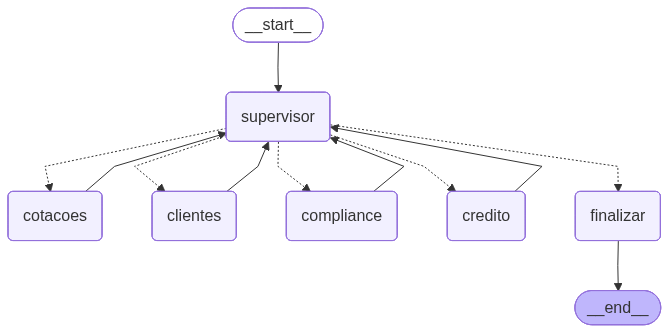

In [44]:
# Visualização do Grafo do Squad Financeiro

from IPython.display import Image, display

print("📊 ARQUITETURA DO SQUAD FINANCEIRO")
print("="*60)

# Gera e exibe o diagrama Mermaid PNG
try:
    graph_image = squad_financeiro.get_graph().draw_mermaid_png()
    display(Image(graph_image))
except Exception as e:
    print(f"   Erro: {e}")
    
    # Alternativa: mostra o código Mermaid
    print("\n📝 Código Mermaid do grafo:")
    print(squad_financeiro.get_graph().draw_mermaid())

In [45]:
# Função auxiliar para interagir com o Squad

def perguntar_ao_squad(pergunta: str, thread_id: str = "demo") -> str:
    """Envia uma pergunta ao Squad Financeiro."""
    
    estado_inicial = {
        "mensagens": [HumanMessage(content=pergunta)],
        "proximo_agente": None,
        "agente_atual": None,
        "contexto": [],
        "resposta_final": None,
        "iteracoes": 0
    }
    
    config = {"configurable": {"thread_id": thread_id}}
    resultado = squad_financeiro.invoke(estado_inicial, config)
    
    return resultado.get("resposta_final", "Sem resposta")

print("✅ Função perguntar_ao_squad definida!")

✅ Função perguntar_ao_squad definida!


In [46]:
# TESTE 1: Consulta de Cotações

print("\n" + "="*70)
print("🧪 TESTE 1: Consulta de Cotações")
print("="*70)

# IMPORTANTE: Usar thread_id único para cada teste evita conflitos de memória!
resposta = perguntar_ao_squad("Qual a cotação atual da PETR4", thread_id="teste_1")
print("\n" + "="*70)
print("📤 RESPOSTA FINAL:")
print("="*70)
print(resposta)


🧪 TESTE 1: Consulta de Cotações

🎯 [SUPERVISOR] Analisando requisição...
   → Agente selecionado: cotacoes
   → Motivo: O usuário solicitou a cotação atual da PETR4, que deve ser processada pelo agente especializado em cotações.

🤖 [Agente de Cotações] Processando...
   🔧 Ferramenta: consultar_cotacao
   ✅ Resposta gerada

🎯 [SUPERVISOR] Analisando requisição...
   → Agente selecionado: finalizar
   → Motivo: A solicitação do usuário sobre a cotação atual da PETR4 já foi atendida pelo agente de cotações.

📝 [FINALIZADOR] Consolidando respostas de todos os agentes...
   📋 Consolidando 2 respostas...

📤 RESPOSTA FINAL:
A cotação atual da ação PETR4 (Petrobras) é de R$ 38,52, com uma alta de 2,3% em relação ao último fechamento. Se você precisar de mais informações ou análises sobre essa ação, estou à disposição para ajudar!


In [47]:
# TESTE 2: Simulação de Crédito

print("\n" + "="*70)
print("🧪 TESTE 2: Simulação de Crédito")
print("="*70)

# IMPORTANTE: Usar thread_id único para cada teste!
resposta = perguntar_ao_squad("Quero simular um empréstimo de R$ 50.000 em 36 meses E SABER A COTACAO DA PETR4", thread_id="teste_2")

print("\n" + "="*70)
print("📤 RESPOSTA FINAL:")
print("="*70)
print(resposta)


🧪 TESTE 2: Simulação de Crédito

🎯 [SUPERVISOR] Analisando requisição...
   → Agente selecionado: credito
   → Motivo: O usuário solicitou a simulação de um empréstimo, portanto, o agente de crédito deve ser acionado primeiro.

🤖 [Agente de Crédito] Processando...
   🔧 Ferramenta: simular_emprestimo
   🔧 Ferramenta: consultar_limite_credito
   ✅ Resposta gerada

🎯 [SUPERVISOR] Analisando requisição...
   → Agente selecionado: cotacoes
   → Motivo: O usuário ainda não recebeu a cotação da PETR4, que é uma parte da solicitação original.

🤖 [Agente de Cotações] Processando...
   🔧 Ferramenta: consultar_cotacao
   🔧 Ferramenta: consultar_historico
   ✅ Resposta gerada

🎯 [SUPERVISOR] Analisando requisição...
   → Agente selecionado: finalizar
   → Motivo: Todas as partes da solicitação foram atendidas: a simulação do empréstimo foi realizada e a cotação da PETR4 foi fornecida.

📝 [FINALIZADOR] Consolidando respostas de todos os agentes...
   📋 Consolidando 6 respostas...

📤 RESPOSTA FINAL

In [48]:
# TESTE 3: Consulta de Cliente

print("\n" + "="*70)
print("🧪 TESTE 3: Consulta de Cliente")
print("="*70)

# IMPORTANTE: Usar thread_id único para cada teste!
resposta = perguntar_ao_squad("Me mostre os dados do cliente CPF 123.456.789-00", thread_id="teste_3")

print("\n" + "="*70)
print("📤 RESPOSTA FINAL:")
print("="*70)
print(resposta)


🧪 TESTE 3: Consulta de Cliente

🎯 [SUPERVISOR] Analisando requisição...
   → Agente selecionado: clientes
   → Motivo: O usuário solicitou os dados do cliente, que devem ser fornecidos pelo agente especializado em gestão de clientes.

🤖 [Agente de Clientes] Processando...
   🔧 Ferramenta: consultar_cliente
   ✅ Resposta gerada

🎯 [SUPERVISOR] Analisando requisição...
   → Agente selecionado: finalizar
   → Motivo: Todos os dados do cliente foram fornecidos pelo agente de clientes e não há mais solicitações pendentes.

📝 [FINALIZADOR] Consolidando respostas de todos os agentes...
   📋 Consolidando 2 respostas...

📤 RESPOSTA FINAL:
Aqui estão os dados do cliente com CPF 123.456.789-00:

- **Nome:** Maria Silva Santos  
- **Tipo de Cliente:** Pessoa Física (PF)  
- **Segmento:** Private  
- **Data de Ingresso:** 15 de março de 2018  
- **Gerente Responsável:** Carlos Eduardo  

Se precisar de mais informações ou de outros serviços, estou à disposição!


In [49]:
# TESTE 4: Verificação de Compliance

print("\n" + "="*70)
print("🧪 TESTE 4: Verificação de Compliance")
print("="*70)

# IMPORTANTE: Usar thread_id único para cada teste!
resposta = perguntar_ao_squad("Qual o nível de risco de uma operação de crédito de R$ 300.000?", thread_id="teste_4")

print("\n" + "="*70)
print("📤 RESPOSTA FINAL:")
print("="*70)
print(resposta)


🧪 TESTE 4: Verificação de Compliance

🎯 [SUPERVISOR] Analisando requisição...
   → Agente selecionado: credito
   → Motivo: O usuário está perguntando sobre o nível de risco de uma operação de crédito, o que requer a análise do agente especializado em crédito.

🤖 [Agente de Crédito] Processando...
   ✅ Resposta gerada

🎯 [SUPERVISOR] Analisando requisição...
   → Agente selecionado: compliance
   → Motivo: É necessário verificar se há restrições ou regulamentações que possam impactar a operação de crédito de R$ 300.000.

🤖 [Agente de Compliance] Processando...
   🔧 Ferramenta: calcular_risco_operacao
   ✅ Resposta gerada

🎯 [SUPERVISOR] Analisando requisição...
   → Agente selecionado: finalizar
   → Motivo: Todas as partes da solicitação foram atendidas, incluindo a análise de risco da operação de crédito e as verificações de conformidade.

📝 [FINALIZADOR] Consolidando respostas de todos os agentes...
   📋 Consolidando 6 respostas...

📤 RESPOSTA FINAL:
**Análise de Risco da Operação 

---

## 📚 Parte 6: Introdução ao MCP (Model Context Protocol)

### 6.1 O que é MCP?

O **Model Context Protocol (MCP)** é um protocolo aberto criado pela Anthropic para padronizar a comunicação entre aplicações de IA e fontes de dados externas.

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                        ARQUITETURA MCP                                       │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                              │
│    ┌─────────────────┐                     ┌─────────────────┐               │
│    │   APLICAÇÃO     │  ←── JSON-RPC ───→  │  SERVIDOR MCP   │               │
│    │   (Cliente)     │    (HTTP/stdio)     │  (Provider)     │               │
│    │                 │                     │                 │               │
│    │  • Seu código   │                     │  • Ferramentas  │               │
│    │  • Claude       │                     │  • Recursos     │               │
│    │  • VS Code      │                     │  • Prompts      │               │
│    └─────────────────┘                     └─────────────────┘               │
│                                                                              │
└─────────────────────────────────────────────────────────────────────────────┘
```

### 6.2 Servidor MCP Público da OpenAI

A OpenAI disponibiliza um servidor MCP público para consultar sua documentação:

🌐 **URL:** `https://developers.openai.com/mcp`

Este servidor oferece:
- 🔍 **search_developer_docs**: Busca na documentação da OpenAI
- 📄 **read_developer_docs**: Lê o conteúdo de uma página específica

Vamos usar este servidor REAL para demonstrar o MCP em ação!

---

In [21]:
# ============================================================
# INSTALAÇÃO DO CLIENTE MCP
# ============================================================

# O pacote langchain-mcp-adapters permite conectar a servidores MCP
# nest_asyncio permite rodar async no Jupyter
%pip install langchain-mcp-adapters httpx-sse nest_asyncio --quiet

import nest_asyncio
nest_asyncio.apply()

print("✅ Cliente MCP instalado e asyncio configurado para Jupyter!")

Note: you may need to restart the kernel to use updated packages.
✅ Cliente MCP instalado e asyncio configurado para Jupyter!


In [22]:
# ============================================================
# CONECTANDO AO SERVIDOR MCP DA OPENAI
# ============================================================

from langchain_mcp_adapters.client import MultiServerMCPClient
import asyncio

print("🔗 CONECTANDO AO SERVIDOR MCP DA OPENAI")
print("=" * 70)
print("🌐 URL: https://developers.openai.com/mcp")
print()

# Configuração do cliente MCP (nova API 0.1.0+)
mcp_config = {
    "openaiDocs": {
        "url": "https://developers.openai.com/mcp",
        "transport": "streamable_http"
    }
}

# Cria o cliente MCP (nova forma sem context manager)
cliente_mcp = MultiServerMCPClient(mcp_config)

# Função para listar ferramentas do servidor MCP
async def listar_ferramentas_mcp():
    tools = await cliente_mcp.get_tools()
    return tools

# Executa e obtém as ferramentas
try:
    ferramentas_mcp = asyncio.get_event_loop().run_until_complete(listar_ferramentas_mcp())
    
    print(f"✅ Conectado! {len(ferramentas_mcp)} ferramentas disponíveis:\n")
    
    for tool in ferramentas_mcp:
        print(f"🔧 {tool.name}")
        desc = tool.description if hasattr(tool, 'description') else str(tool)
        print(f"   {desc[:100]}..." if len(desc) > 100 else f"   {desc}")
        print()
        
except Exception as e:
    print(f"⚠️ Erro ao conectar: {e}")
    print("\n💡 Possíveis causas:")
    print("   • Sem conexão com a internet")
    print("   • Servidor MCP temporariamente indisponível")
    print("   • Versão do pacote incompatível")

🔗 CONECTANDO AO SERVIDOR MCP DA OPENAI
🌐 URL: https://developers.openai.com/mcp

✅ Conectado! 5 ferramentas disponíveis:

🔧 search_openai_docs
   Search across `platform.openai.com` + `developers.openai.com` docs. Use this whenever you are workin...

🔧 list_openai_docs
   List/browse pages from `platform.openai.com` + `developers.openai.com` that this server crawls (usef...

🔧 fetch_openai_doc
   Fetch the markdown for a specific doc page (from `developers.openai.com` or `platform.openai.com`) s...

🔧 list_api_endpoints
   List all OpenAI API endpoint URLs available in the OpenAPI spec.

🔧 get_openapi_spec
   Return the OpenAPI spec for a specific API endpoint URL. Optionally filter code samples by language,...



---

## 🧪 Parte 7: Testando o Servidor MCP da OpenAI

Vamos usar as ferramentas do servidor MCP para buscar informações na documentação da OpenAI!

In [23]:
# ============================================================
# TESTE 1: Buscando na Documentação da OpenAI
# ============================================================

print("🔍 TESTE: Buscando 'function calling' na documentação OpenAI")
print("=" * 70)

async def buscar_documentacao(query: str):
    """Busca na documentação da OpenAI usando o servidor MCP."""
    tools = await cliente_mcp.get_tools()
    
    # Encontra a ferramenta de busca
    search_tool = None
    for tool in tools:
        if "search" in tool.name.lower():
            search_tool = tool
            break
    
    if search_tool:
        # Invoca a ferramenta de busca
        resultado = await search_tool.ainvoke({"query": query})
        return resultado
    return "Ferramenta de busca não encontrada"

try:
    resultado_busca = asyncio.get_event_loop().run_until_complete(
        buscar_documentacao("function calling tools")
    )
    
    print("\n📄 Resultado da busca:")
    print("-" * 70)
    # Mostra resultado (limitando tamanho para não poluir)
    resultado_str = str(resultado_busca)
    if len(resultado_str) > 2000:
        print(resultado_str[:2000] + "\n\n... [truncado para exibição]")
    else:
        print(resultado_str)
        
except Exception as e:
    print(f"⚠️ Erro na busca: {e}")

🔍 TESTE: Buscando 'function calling' na documentação OpenAI

📄 Resultado da busca:
----------------------------------------------------------------------
[{'type': 'text', 'text': '{\n  "hits": [\n    {\n      "url": "https://developers.openai.com/codex/guides/build-ai-native-engineering-team/#ai-coding-from-autocomplete-to-agents",\n      "url_without_anchor": "https://developers.openai.com/codex/guides/build-ai-native-engineering-team/",\n      "anchor": "ai-coding-from-autocomplete-to-agents",\n      "content": "AI coding tools have progressed far beyond their origins as autocomplete assistants. Early tools handled quick tasks such as suggesting the next line of code or filling in function templates. As models gained stronger reasoning abilities, developers began interacting with agents through chat interfaces in IDEs for pair programming and code exploration.\\r\\nToday’s coding agents can generate entire files, scaffold new projects, and translate designs into code. They can reaso

---

## 🤖 Parte 8: Criando um Agente que Usa o MCP

Agora vamos criar um agente LangGraph que usa as ferramentas do servidor MCP da OpenAI!

In [50]:
# ============================================================
# AGENTE LANGGRAPH + MCP
# ============================================================

from langgraph.prebuilt import create_react_agent

print("🤖 CRIANDO AGENTE COM FERRAMENTAS MCP")
print("=" * 70)

async def criar_e_executar_agente_mcp(pergunta: str):
    """Cria um agente que usa ferramentas do servidor MCP da OpenAI."""
    
    # Obtém ferramentas do servidor MCP
    tools = await cliente_mcp.get_tools()
    
    print(f"📦 Ferramentas MCP carregadas: {len(tools)}")
    for t in tools:
        print(f"   • {t.name}")
    
    # Cria agente ReAct com as ferramentas MCP
    agente_mcp = create_react_agent(
        model=llm,
        tools=tools
    )
    
    print(f"\n❓ Pergunta: {pergunta}")
    print("-" * 70)
    
    # Executa o agente
    resultado = await agente_mcp.ainvoke({
        "messages": [("user", pergunta)]
    })
    
    # Extrai a resposta final
    resposta = resultado["messages"][-1].content
    return resposta

# Teste do agente - pergunta mais simples
try:
    resposta_agente = asyncio.get_event_loop().run_until_complete(
        criar_e_executar_agente_mcp(
            "O que é function calling na API da OpenAI? Explique em 2 frases."
        )
    )
    
    print("\n🤖 Resposta do Agente:")
    print("=" * 70)
    print(resposta_agente)
    
except Exception as e:
    print(f"\n⚠️ Erro: {e}")
    print("""
💡 O servidor MCP da OpenAI pode retornar erros em algumas páginas.
   Isso é normal - nem toda documentação está disponível.
   O importante é que a CONEXÃO MCP funcionou!
""")

🤖 CRIANDO AGENTE COM FERRAMENTAS MCP
📦 Ferramentas MCP carregadas: 5
   • search_openai_docs
   • list_openai_docs
   • fetch_openai_doc
   • list_api_endpoints
   • get_openapi_spec

❓ Pergunta: O que é function calling na API da OpenAI? Explique em 2 frases.
----------------------------------------------------------------------


C:\Users\ioann\AppData\Local\Temp\ipykernel_12264\1121245194.py:21: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agente_mcp = create_react_agent(



🤖 Resposta do Agente:
Function calling na API da OpenAI é um recurso que permite que modelos acessem funcionalidades e dados externos para seguir instruções e responder a prompts. Ele possibilita que o modelo faça chamadas a funções definidas, permitindo a execução de ações específicas, como obter dados ou realizar operações, com base nas solicitações do usuário.


In [27]:
# ============================================================
# COMPARAÇÃO: Nossas LangChain Tools vs MCP Tools
# ============================================================

print("📊 COMPARAÇÃO: LANGCHAIN TOOLS vs MCP TOOLS")
print("=" * 70)

print("""
┌─────────────────────────────────────────────────────────────────────────┐
│                    NOSSA TOOL LANGCHAIN                                  │
├─────────────────────────────────────────────────────────────────────────┤
│  @tool                                                                   │
│  def consultar_cotacao(ativo: str) -> str:                               │
│      '''Consulta a cotação atual de um ativo.'''                         │
│      # ... implementação ...                                             │
│      return f"{ativo}: R$ {preco}"                                       │
│                                                                          │
│  ✓ Função Python rodando NO MESMO PROCESSO                               │
│  ✓ Acesso direto a variáveis e banco de dados locais                     │
│  ✓ Ideal para aplicações monolíticas                                     │
└─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                    FERRAMENTA MCP (OPENAI DOCS)                          │
├─────────────────────────────────────────────────────────────────────────┤
│  🌐 URL: https://developers.openai.com/mcp                               │
│                                                                          │
│  {                                                                       │
│    "name": "search_developer_docs",                                      │
│    "description": "Search OpenAI developer documentation",               │
│    "inputSchema": {"query": {"type": "string"}}                          │
│  }                                                                       │
│                                                                          │
│  ✓ Servidor REMOTO acessível via HTTP                                    │
│  ✓ Qualquer cliente MCP pode usar (Claude, VS Code, seu código)          │
│  ✓ Ideal para ecossistema de ferramentas compartilhadas                  │
└─────────────────────────────────────────────────────────────────────────┘
""")

print("\n🎯 QUANDO USAR CADA UM:")
print("-" * 70)
print("""
USE LANGCHAIN TOOLS quando:
  • Ferramentas são específicas da sua aplicação
  • Precisa de acesso a dados locais/privados
  • Quer simplicidade e performance
  
USE MCP quando:
  • Quer expor ferramentas para MÚLTIPLOS clientes
  • Quer usar ferramentas de TERCEIROS (como OpenAI Docs)
  • Precisa de isolamento entre processos
""")

📊 COMPARAÇÃO: LANGCHAIN TOOLS vs MCP TOOLS

┌─────────────────────────────────────────────────────────────────────────┐
│                    NOSSA TOOL LANGCHAIN                                  │
├─────────────────────────────────────────────────────────────────────────┤
│  @tool                                                                   │
│  def consultar_cotacao(ativo: str) -> str:                               │
│      '''Consulta a cotação atual de um ativo.'''                         │
│      # ... implementação ...                                             │
│      return f"{ativo}: R$ {preco}"                                       │
│                                                                          │
│  ✓ Função Python rodando NO MESMO PROCESSO                               │
│  ✓ Acesso direto a variáveis e banco de dados locais                     │
│  ✓ Ideal para aplicações monolíticas                                     │
└─────────────────────────────────

In [26]:
# ============================================================
# CONFIGURANDO MCP NO VS CODE / CURSOR (Referência)
# ============================================================

print("⚙️ COMO CONFIGURAR MCP NO SEU EDITOR")
print("=" * 70)

print("""
📁 VS CODE (GitHub Copilot Agent mode)
--------------------------------------
Crie o arquivo .vscode/mcp.json no seu projeto:

{
  "servers": {
    "openaiDeveloperDocs": {
      "type": "http",
      "url": "https://developers.openai.com/mcp"
    }
  }
}


📁 CURSOR
---------
Crie o arquivo ~/.cursor/mcp.json:

{
  "mcpServers": {
    "openaiDeveloperDocs": {
      "url": "https://developers.openai.com/mcp"
    }
  }
}


📁 CLAUDE DESKTOP
-----------------
Edite o arquivo claude_desktop_config.json:

{
  "mcpServers": {
    "openaiDeveloperDocs": {
      "url": "https://developers.openai.com/mcp"
    }
  }
}


💡 DICA: Adicione ao seu AGENTS.md:
"Always use the OpenAI developer documentation MCP server 
if you need to work with the OpenAI API."
""")

print("=" * 70)
print("✅ Com essas configurações, seu editor consulta a documentação automaticamente!")

⚙️ COMO CONFIGURAR MCP NO SEU EDITOR

📁 VS CODE (GitHub Copilot Agent mode)
--------------------------------------
Crie o arquivo .vscode/mcp.json no seu projeto:

{
  "servers": {
    "openaiDeveloperDocs": {
      "type": "http",
      "url": "https://developers.openai.com/mcp"
    }
  }
}


📁 CURSOR
---------
Crie o arquivo ~/.cursor/mcp.json:

{
  "mcpServers": {
    "openaiDeveloperDocs": {
      "url": "https://developers.openai.com/mcp"
    }
  }
}


📁 CLAUDE DESKTOP
-----------------
Edite o arquivo claude_desktop_config.json:

{
  "mcpServers": {
    "openaiDeveloperDocs": {
      "url": "https://developers.openai.com/mcp"
    }
  }
}


💡 DICA: Adicione ao seu AGENTS.md:
"Always use the OpenAI developer documentation MCP server 
if you need to work with the OpenAI API."

✅ Com essas configurações, seu editor consulta a documentação automaticamente!


---

## 📝 Resumo da Aula 4 e do Curso

### O que aprendemos nesta aula:

1. **Arquiteturas Multi-Agentes**
   - Padrões: Hierárquico, Sequencial, Colaborativo
   - Vantagens da especialização de agentes

2. **Padrão Supervisor**
   - Agente coordenador que roteia requisições
   - Decisão estruturada com Pydantic
   - Controle de iterações e memória

3. **MCP (Model Context Protocol)**
   - Protocolo padronizado para integração
   - Conectamos ao servidor MCP REAL da OpenAI
   - Criamos um agente que consulta documentação via MCP
   - Comparação prática: LangChain Tools vs MCP

4. **Squad Financeiro**
   - 4 agentes especializados (Cotações, Clientes, Compliance, Crédito)
   - 1 supervisor coordenador
   - Sistema completo com grafo visualizável

---

### 📚 Resumo do Curso Completo

| Aula | Tema | Principais Conceitos |
|------|------|---------------------|
| **1** | Agentes Cognitivos | Chains vs Agents, ReAct, Tools, Memory |
| **2** | RAG e Compliance | Extração estruturada, Embeddings, ChromaDB |
| **3** | LangGraph | Estados, Nós, Arestas, Human-in-the-Loop |
| **4** | Multi-Agentes e MCP | Supervisor, Especialização, Protocolo MCP |

---

### 🚀 Próximos Passos Sugeridos

1. **MCP no seu editor**: Configure o servidor da OpenAI no VS Code/Cursor
2. **Crie seu próprio servidor MCP**: Exponha seu Squad via MCP para outras equipes
3. **Produção**: Substituir MemorySaver por PostgreSQL/Redis
4. **Monitoramento**: Adicionar LangSmith para observabilidade

---

### 🎓 Parabéns por completar o curso!

Você agora tem conhecimento para:
- ✅ Criar agentes inteligentes com LangChain
- ✅ Implementar sistemas RAG para compliance
- ✅ Orquestrar fluxos complexos com LangGraph
- ✅ Construir arquiteturas multi-agentes
- ✅ Conectar e usar servidores MCP reais

**Sucesso na sua jornada com IA Agêntica!** 🚀